### 任务2 - 特征工程
- 特征衍生
- 特征挑选：分别用IV值和随机森林等进行特征选择

In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 100)

df = pd.read_csv('train.csv', encoding = 'GBK')
print(df.shape)

(3327, 86)


#### 分箱+IV

In [2]:
# Ref:
# https://medium.com/@sundarstyles89/weight-of-evidence-and-information-value-using-python-6f05072e83eb
# https://nbviewer.jupyter.org/github/Sundar0989/WOE-and-IV/blob/master/WOE_IV.ipynb

import pandas.core.algorithms as algos
from pandas import Series
import scipy.stats.stats as stats
import re
import traceback
import string

max_bin = 10
force_bin = 3

# Bining for numeric variables
def mono_bin(Y, X, n = max_bin):
    
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]
    r = 0
    while np.abs(r) < 1:
        try:
            d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.qcut(notmiss.X, n)})
            d2 = d1.groupby('Bucket', as_index=True)
            r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
            n = n - 1 
        except Exception as e:
            n = n - 1

    if len(d2) == 1:
        n = force_bin         
        bins = algos.quantile(notmiss.X, np.linspace(0, 1, n))
        if len(np.unique(bins)) == 2:
            bins = np.insert(bins, 0, 1)
            bins[1] = bins[1]-(bins[1]/2)
        d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.cut(notmiss.X, np.unique(bins),include_lowest=True)}) 
        d2 = d1.groupby('Bucket', as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["MIN_VALUE"] = d2.min().X
    d3["MAX_VALUE"] = d2.max().X
    d3["COUNT"] = d2.count().Y
    d3["EVENT"] = d2.sum().Y
    d3["NONEVENT"] = d2.count().Y - d2.sum().Y
    d3=d3.reset_index(drop=True)
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]       
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    
    return(d3)

# Bining for character variables
def char_bin(Y, X):
        
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]    
    df2 = notmiss.groupby('X',as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["COUNT"] = df2.count().Y
    d3["MIN_VALUE"] = df2.sum().Y.index
    d3["MAX_VALUE"] = d3["MIN_VALUE"]
    d3["EVENT"] = df2.sum().Y
    d3["NONEVENT"] = df2.count().Y - df2.sum().Y
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]      
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    d3 = d3.reset_index(drop=True)
    
    return(d3)

def data_vars(df1, target):
    
    stack = traceback.extract_stack()
    filename, lineno, function_name, code = stack[-2]
    vars_name = re.compile(r'\((.*?)\).*$').search(code).groups()[0]
    final = (re.findall(r"[\w']+", vars_name))[-1]
    
    x = df1.dtypes.index
    count = -1
    
    for i in x:
        if i.upper() not in (final.upper()):
            if np.issubdtype(df1[i], np.number) and len(Series.unique(df1[i])) > 2:
                conv = mono_bin(target, df1[i])
                conv["VAR_NAME"] = i
                count = count + 1
            else:
                conv = char_bin(target, df1[i])
                conv["VAR_NAME"] = i            
                count = count + 1
                
            if count == 0:
                iv_df = conv
            else:
                iv_df = iv_df.append(conv,ignore_index=True)
    
    iv = pd.DataFrame({'IV':iv_df.groupby('VAR_NAME').IV.max()})
    iv = iv.reset_index()
    return(iv_df,iv)

In [ ]:
final_iv, IV = data_vars(df, df.status)

In [4]:
IV.sort_values('IV').tail(30)

,VAR_NAME,IV
15,consume_top_time_last_1_month,0.015572
56,number_of_trans_from_2011,0.018022
38,loans_count,0.020031
6,avg_price_top_last_12_valid_month,0.020694
5,avg_price_last_12_month,0.021526
10,consfin_max_limit,0.022701
59,query_cash_count,0.022863
77,trans_days_interval,0.024246
14,consume_mini_time_last_1_month,0.032714
9,consfin_credit_limit,0.032953


#### Random Forest 随机森林

In [5]:
# Ref:
# https://www.datascience.com/resources/notebooks/random-forest-intro

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier

df = df.drop(['latest_query_time', 'loans_latest_time', 'source'],axis = 1)
training_set = df.iloc[:, df.columns != 'status']
class_set = df.iloc[:, df.columns == 'status']

class_set = class_set.values.ravel()
fit_rf = RandomForestClassifier(random_state=2018)

In [6]:
# TO-DO: Hyperparameter tuning - GridSearchCV
fit_rf.set_params(criterion = 'gini',
                  max_features = 'log2',
                  max_depth = 3,
                  n_estimators=400,
                  bootstrap = True,
                  warm_start=False,
                  oob_score=False)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=3, max_features='log2', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=None, oob_score=False, random_state=2018,
                       verbose=0, warm_start=False)

In [7]:
#training_set.info()
fit_rf.fit(training_set, class_set)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=3, max_features='log2', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=None, oob_score=False, random_state=2018,
                       verbose=0, warm_start=False)

In [9]:
# Feature importance analysis
importances_rf = fit_rf.feature_importances_
indices_rf = np.argsort(importances_rf)[::-1]

In [14]:
def variable_importance(importance, indices):
    print("Feature ranking:")

    for f in range(len(training_set.columns)):
        i = f
        print("%d. '%s' = %f" %\
             (f + 1, training_set.columns[indices[i]], importance[indices[f]]))
        
variable_importance(importances_rf, indices_rf)

Feature ranking:
1. 'history_fail_fee' = 0.136669
2. 'trans_fail_top_count_enum_last_1_month' = 0.129052
3. 'loans_score' = 0.080629
4. 'loans_overdue_count' = 0.077484
5. 'latest_one_month_fail' = 0.071960
6. 'apply_score' = 0.067702
7. 'trans_fail_top_count_enum_last_12_month' = 0.043773
8. 'trans_fail_top_count_enum_last_6_month' = 0.036833
9. 'trans_day_last_12_month' = 0.027856
10. 'latest_one_month_suc' = 0.023094
11. 'rank_trad_1_month' = 0.022268
12. 'max_cumulative_consume_later_1_month' = 0.021820
13. 'trans_top_time_last_1_month' = 0.016533
14. 'consume_top_time_last_1_month' = 0.015840
15. 'latest_three_month_loan' = 0.012727
16. 'trans_amount_3_month' = 0.011241
17. 'top_trans_count_last_1_month' = 0.010163
18. 'consfin_avg_limit' = 0.009172
19. 'latest_query_day' = 0.008994
20. 'pawns_auctions_trusts_consume_last_1_month' = 0.007535
21. 'latest_six_month_loan' = 0.006595
22. 'consfin_max_limit' = 0.006549
23. 'loans_org_count_behavior' = 0.006044
24. 'consfin_credit_limit

In [63]:
import matplotlib.pyplot as plt

def variable_importance_plot(importance, indices):
    
    index = np.arange(len(training_set.columns))

    importance_desc = sorted(importance)
    feature_space = []
    for i in range(81, -1, -1):
        feature_space.append(training_set.columns[indices[i]])

    fig, ax = plt.subplots(figsize=(10, 10))

    ax.set_facecolor('#fafafa')
    plt.title('Feature importances for Random Forest Model')
    plt.barh(index, importance_desc, align="center", color = '#875FDB')
    plt.yticks(index, feature_space)

    plt.ylim(50.5, 81.5)
    plt.xlim(0, max(importance_desc))
    plt.xlabel('Mean Decrease in Gini')
    plt.ylabel('Feature')

    plt.show()
    plt.close()

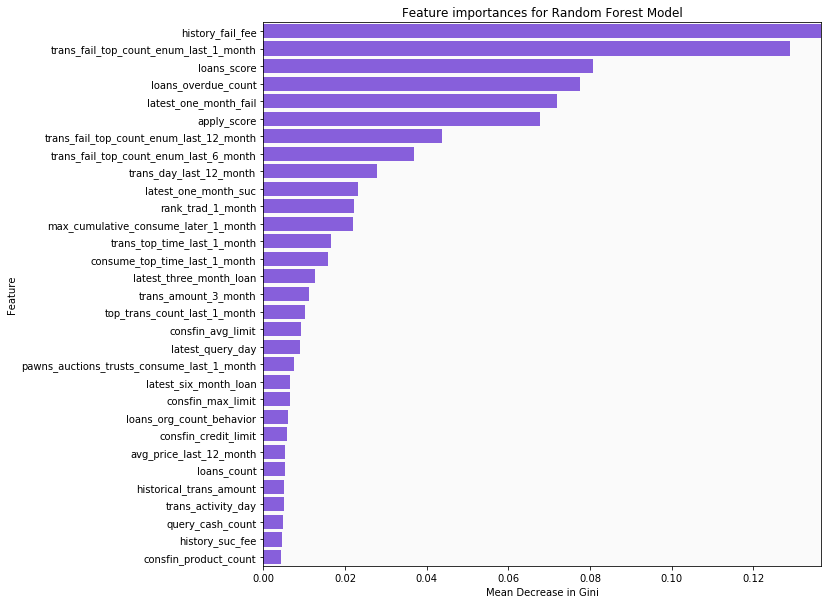

In [64]:
variable_importance_plot(importances_rf, indices_rf)